# Build a surrogate model in the same fashion as Du et al. for Actuator Position RL

Import required packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from joblib import dump, load
from datetime import datetime
import psutil
import os
from os import path
import time
import random
from typing import Optional
import tkinter as tk
from tkinter.messagebox import showinfo
import gym
from gym import spaces
import ansys
from ansys.mapdl.core import launch_mapdl
from ansys.mapdl import reader as mapdl_reader

c:\Users\TL\Documents\PythonVENV\venv3_10-pyAnsys\lib\site-packages\scooby\knowledge.py:14: DeprecationWarning: The distutils.sysconfig module is deprecated, use sysconfig instead
  import distutils.sysconfig as sysconfig


In [2]:
st= time.time()

Build reusable code

In [3]:
class generateSurrogateData():
    def __init__(self):
        # Parse the Ansys input file
        #filepath = path.join(path.dirname(__file__),'Undeformed.inp')
        filepath = './SolutionInputUndeformed1.inp'
        with open(filepath, 'r') as f:
            text = f.read()
            new_text = text.split('/com,******************* SOLVE FOR LS 1 OF 1 ****************')
            self.setup_text = new_text[0]
            new_text = text.split('! *********** WB SOLVE COMMAND ***********')
            self.finish_text = new_text[1]
            f.close()

    def _launch_ansys(self):
        # Launch ANSYS
        try:
            n_cpu = psutil.cpu_count(logical=False)
            self.mapdl = launch_mapdl(loglevel='ERROR', verbose=False, nproc=n_cpu, cleanup_on_exit=True, override=True) 
            print(self.mapdl)
            print("Running on", n_cpu, "processors")
        except:
            n_cpu=min(4, n_cpu) #license sometimes won't let me use more than 4 processors?
            self.mapdl = launch_mapdl(loglevel='ERROR', verbose=False, nproc=n_cpu, cleanup_on_exit=True, override=True) 
            print(self.mapdl)
            print("Running on", n_cpu, "processors")

    def _set_actuator_forces(self, mapdl, forces):
        # Calculate y and z components of the forces from desired magnitudes
        angles = np.linspace(12, -192, 18)
        self.forces_Y = forces*np.cos(np.deg2rad(angles))
        self.forces_Z = forces*np.sin(np.deg2rad(angles))

        for i in range(0,18):
            # Set x component of force (practically zero)
            mapdl.esel("s", "real", "", 43+3*i)
            mapdl.sfe("all", 1, "pres", 1, 2.24808943074769e-009)
            # Set y component of force
            mapdl.esel("s", "real", "", 44+3*i)
            mapdl.sfe("all", 1, "pres", 1, self.forces_Y[i])
            # Set z component of force
            mapdl.esel("s", "real", "", 45+3*i)
            mapdl.sfe("all", 1, "pres", 1, self.forces_Z[i])
            
        mapdl.esel("all")   # make sure everything is selected before running solve 

        # Run the solution
        mapdl._run("/nopr")
        mapdl.run("/gopr")
        mapdl.run("nsub,1,1,1")
        mapdl.time(1.)
        mapdl.outres("erase")
        mapdl.outres("all", "none")
        mapdl.outres("nsol", "all")
        mapdl.outres("rsol", "all")
        mapdl.outres("eangl", "all")
        mapdl.outres("etmp", "all")
        mapdl.outres("veng", "all")
        mapdl.outres("strs", "all")
        mapdl.outres("epel", "all")
        mapdl.outres("eppl", "all")
        mapdl.outres("cont", "all")

    def _get_initPos(self):
        '''
        Get the initial positions of nodes on the fuselage edge before any forces are applied
        '''
        self.mapdl.cmsel(name='CM_FUSELAGE_EDGE') # select nodes on the edge of the fuselage
        initPos = self.mapdl.mesh.nodes # initial positions of nodes
        nnum = self.mapdl.mesh.nnum # corresponding node numbers
        self.mapdl.allsel()
        return initPos[:,1:3]    

    def _get_displacement(self):
        '''
        Get the displacement of nodes on the fuselage edge after forces have been applied. 
        The displacements are relative to the initial positions of the nodes.
        '''
        self.mapdl.cmsel(name='CM_FUSELAGE_EDGE') # select nodes on the edge of the fuselage
        displacements = self.mapdl.post_processing.nodal_displacement('ALL') # get displacements of nodes on the edge
        total = self.mapdl.post_processing.nodal_displacement('NORM')
        self.mapdl.allsel()
        return displacements[:,1:3], total

    def _monitor_process(self, processName):
        flag = False
        #Iterate over the all the running process
        for proc in psutil.process_iter():
            try:
                # Check if process name contains the given name string.
                if processName.lower() in proc.name().lower():
                    flag = True
            except (psutil.NoSuchProcess, psutil.AccessDenied, psutil.ZombieProcess):
                pass
        return flag

    def _run_ansys(self, forces):
        self.forces=forces       
        try:
            if not self._monitor_process('ansys'):
                self._launch_ansys()  
            # Clear solver memory
            self.mapdl.finish()
            self.mapdl.clear()
            #print("Ready to run")
            # Setup and run the simulation
            log1 = self.mapdl.input_strings(self.setup_text) # run setup
            log2 = self._set_actuator_forces(self.mapdl, self.forces) # apply forces
            log3 = self.mapdl.input_strings(self.finish_text) # complete solution
            self.result = self.mapdl.result # store result
            #print("Results are available")
        
        except:
            print("Exit Ansys and try to reconnect")
            
            try:
                self.mapdl.exit()
                print("Remote exit")
                time.sleep(10)
            except:
                print("No active Ansys process found. Wait and try to reconnect")
                time.sleep(10)
                
            i = 0
            while True:
                i += 1
                try: 
                    self._launch_ansys()
                    print("Sucessfully reconnected to Ansys on attempt", i)
                    print("Try running again")
                    log1 = self.mapdl.input_strings(self.setup_text) # run setup
                    print("Simulation setup complete")
                    log2 = self._set_actuator_forces(self.mapdl, self.forces) # apply forces
                    print("Applied forces")
                    log3 = self.mapdl.input_strings(self.finish_text) # complete solution
                    print("Solve finished")
                    self.result = self.mapdl.result # store result 
                    print("Results ready")         
                    
                    break

                except:
                    try:
                        print("Reconnect failed - remote exit again")
                        self.mapdl.exit()
                        time.sleep(10)
                    except:
                        time.sleep(10)
                        if i <=3:
                            print("Wait and try to reconnect again - attempt", i)
                        else:
                            print("Check Ansys license server connection")
                            # Create popup message
                            root = tk.Tk()
                            root.title('Warning')
                            root.geometry('300x150')
                            answer = showwarning(title='Warning',
                                                message='Check Ansys license server connection!')
                            if answer:
                                root.destroy()
                            time.sleep(5)
    
    def run(self, forces):
        self._run_ansys(forces)
        displacements, total = self._get_displacement()
        displacements = np.array(displacements, dtype=np.float32)
        total = np.array(total, dtype=np.float32)
        initPos = np.array(self._get_initPos(), dtype=np.float32)
        return displacements, total, initPos





Verify that generator runs properly

In [4]:
forces=  np.ones(18, dtype=np.float32)  *10

generator = generateSurrogateData()
U, T, P = generator.run(forces)

PyMAPDL is taking longer than expected to connect to an MAPDL session.
Checking if there are any available licenses...
Product:             Ansys Mechanical Enterprise Academic Teaching
MAPDL Version:       22.1
ansys.mapdl Version: 0.64.0

Running on 4 processors


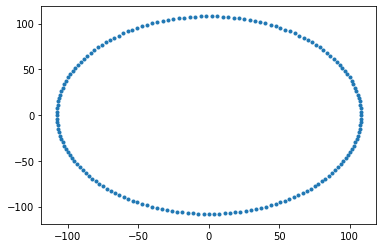

In [5]:
plt.plot(P[:,0],P[:,1],'.')


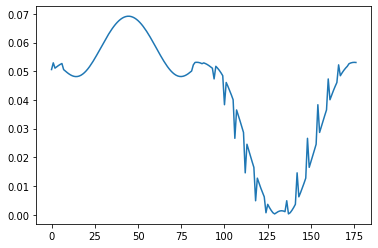

In [6]:
plt.plot(T[:])


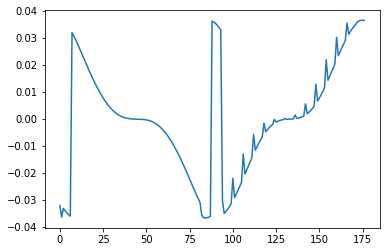

In [7]:
plt.plot(U[:,0])


In [8]:
print(generator.forces_Y)
print(generator.forces_Z)

[  9.78147601  10.           9.78147601   9.13545458   8.09016994
   6.69130606   5.           3.09016994   1.04528463  -1.04528463
  -3.09016994  -5.          -6.69130606  -8.09016994  -9.13545458
  -9.78147601 -10.          -9.78147601]
[ 2.07911691e+00  0.00000000e+00 -2.07911691e+00 -4.06736643e+00
 -5.87785252e+00 -7.43144825e+00 -8.66025404e+00 -9.51056516e+00
 -9.94521895e+00 -9.94521895e+00 -9.51056516e+00 -8.66025404e+00
 -7.43144825e+00 -5.87785252e+00 -4.06736643e+00 -2.07911691e+00
 -1.22464680e-15  2.07911691e+00]


Run with original input file from the first test sample to verify solution is as expected

In [9]:
filepath = './SolutionInputUndeformed1.inp'
with open(filepath, 'r') as f:
    text = f.read()
generator.mapdl.finish()
generator.mapdl.clear()
log = generator.mapdl.input_strings(text)

## Generate training and testing data for the surrogate model

Import training and testing forces from DOE

In [10]:
X_train = np.genfromtxt('X_train.csv', delimiter=',')
X_test = np.genfromtxt('X_test.csv', delimiter=',')
print(X_train[0,:])

[   1.12685092   -8.64784159   21.46708891  109.0712687    27.49434117
  -27.2810437   110.389102     -0.81364652  -44.40039284   91.48842832
   41.90590988   52.52626373   55.48052687  -33.06774062 -196.273765
 -143.5042207   163.9675958   128.6159996 ]


In [11]:
y_train = np.genfromtxt('y_train.csv', delimiter=',')
y_test = np.genfromtxt('y_test.csv', delimiter=',')
ytotal_train = np.genfromtxt('ytotal_train.csv', delimiter=',')
ytotal_test = np.genfromtxt('ytotal_test.csv', delimiter=',')


print(y_train[0,:].shape)

(354,)


In [12]:
generator = generateSurrogateData()

# Generate training data
n= X_train.shape[0]
y_train = np.zeros([n, 177*2])
ytotal_train = np.zeros([n,177])
for i in range(n):
    U, T, P = generator.run(X_train[i,:])
    y_train[i,:]= U.flatten()
    ytotal_train[i,:] = T.flatten()

# Generate test data
n= X_test.shape[0]
y_test = np.zeros([n, 177*2])
ytotal_test = np.zeros([n,177])
for i in range(n):
    U, T, P = generator.run(X_test[i,:])
    y_test[i,:]= U.flatten()
    ytotal_test[i,:] = T.flatten()

# Save to .csv files
np.savetxt("y_train.csv", y_train, delimiter=",")
np.savetxt("y_test.csv", y_test, delimiter=",")
np.savetxt("ytotal_train.csv", ytotal_train, delimiter=",")
np.savetxt("ytotal_test.csv", ytotal_test, delimiter=",")


Exit Ansys and try to reconnect
No active Ansys process found. Wait and try to reconnect
Product:             Ansys Mechanical Enterprise Academic Teaching
MAPDL Version:       22.1
ansys.mapdl Version: 0.64.0

Running on 4 processors
Sucessfully reconnected to Ansys on attempt 1
Try running again
Simulation setup complete
Applied forces
Solve finished
Results ready
Exit Ansys and try to reconnect
Remote exit
Product:             Ansys Mechanical Enterprise Academic Teaching
MAPDL Version:       22.1
ansys.mapdl Version: 0.64.0

Running on 4 processors
Sucessfully reconnected to Ansys on attempt 1
Try running again
Simulation setup complete
Applied forces
Solve finished
Results ready


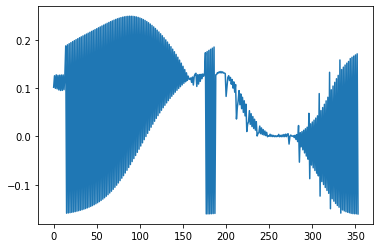

In [13]:
plt.plot(y_train[0,:])

Double-check forces

In [14]:
print(generator.forces)
print(generator.forces_Y)
print(generator.forces_Z)

[ -10.6175274    79.23224111  182.9599033  -143.2338615    42.07934385
   -3.10116392  -76.22478449 -188.8938754   115.8811681   136.1413354
 -153.65844     181.9805169     3.78680034 -101.1327845   -65.62213009
  111.878725   -114.1294333   -79.09982417]
[ -10.38550895   79.23224111  178.96179044 -130.85064355   34.04290429
   -2.07508369  -38.11239225  -58.37141763   12.11288042  -14.23064458
   47.48306929  -90.99025845   -2.53386401   81.81814135   59.94879886
 -109.43390643  114.1294333    77.37130323]
[-2.20750807e+00  0.00000000e+00 -3.80395028e+01  5.82584600e+01
 -2.47336177e+01  2.30461392e+00  6.60125998e+01  1.79648751e+02
 -1.15246359e+02 -1.35395539e+02  1.46137861e+02 -1.57599751e+02
 -2.81414108e+00  5.94443593e+01  2.66909249e+01 -2.32608949e+01
  1.39768245e-14 -1.64457782e+01]


Print simulation results to check against results in Ansys

In [15]:
print(max(generator.mapdl.post_processing.nodal_displacement('NORM')))
print(max(generator.mapdl.post_processing.nodal_displacement('Y')))
print(max(generator.mapdl.post_processing.nodal_displacement('Z')))
print(max(generator.mapdl.post_processing.nodal_displacement('X')))


1.3723933626415872
1.3719345329380257
0.49052327237144305
0.0014691115391062177


In [16]:
generator.mapdl.post_processing.plot_nodal_displacement('NORM',
                                              smooth_shading=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## Run linear regression

[-6.85843257e-16 -7.93162257e-16 -1.20834562e-15 -7.98246497e-16
 -6.64465038e-16]
Training error (total deformation = 1.5040789615000084e-06
Testing error (total deformation = 1.607809761358101e-06
Training error (MAE) total displacement = 1.1845296017092057e-08
Testing error (MAE) total displacement = 1.8894600947232276e-08
Training $R^2$ = 0.9999999999999997
Testing $R^2$ = 0.9999999999999984


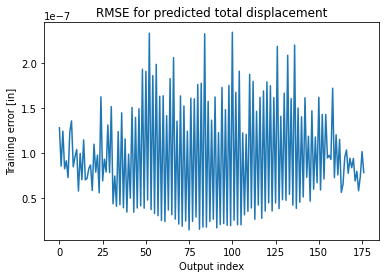

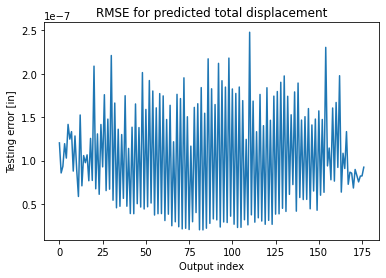

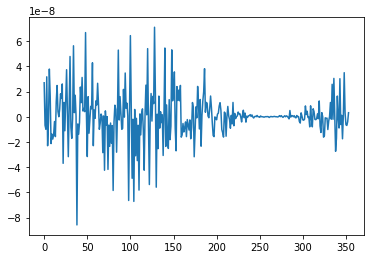

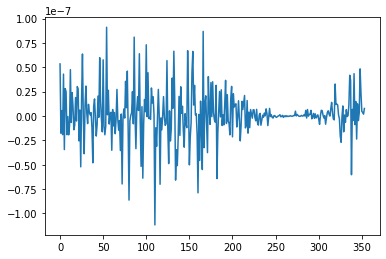

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics


reg = linear_model.LinearRegression()

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(scores)

reg.fit(X_train, y_train)

# Get training error
yhat_train = reg.predict(X_train)
ytotal_train = np.sqrt(np.square(y_train[:,:177]) + np.square(y_train[:,177:]))
yhat_total_train = np.sqrt(np.square(yhat_train[:,:177]) + np.square(yhat_train[:,177:]))
totalTE = ytotal_train - yhat_total_train
print('Training error (total deformation =', np.linalg.norm(totalTE))

RMSETP = np.sqrt(np.sum(abs(np.square(totalTE)), axis=0))
fig = plt.subplots()
plt.plot(RMSETP)
plt.title('RMSE for predicted total displacement')
plt.xlabel('Output index')
plt.ylabel('Training error [in]')
plt.show


# Get test error
yhat_test = reg.predict(X_test)
ytotal_test = np.sqrt(np.square(y_test[:,:177]) + np.square(y_test[:,177:]))
yhat_total_test = np.sqrt(np.square(yhat_test[:,:177]) + np.square(yhat_test[:,177:]))
totalTE = ytotal_test - yhat_total_test
print('Testing error (total deformation =', np.linalg.norm(totalTE))

RMSETP = np.sqrt(np.sum(abs(np.square(totalTE)), axis=0))
fig = plt.subplots()
plt.plot(RMSETP)
plt.title('RMSE for predicted total displacement')
plt.xlabel('Output index')
plt.ylabel('Testing error [in]')
plt.show

# print('Training error (MAE) =', metrics.mean_absolute_error(y_train, yhat_train))
# print('Testing error (MAE) =', metrics.mean_absolute_error(y_test, yhat_test))
print('Training error (MAE) total displacement =', metrics.mean_absolute_error(ytotal_train, yhat_total_train))
print('Testing error (MAE) total displacement =', metrics.mean_absolute_error(ytotal_test, yhat_total_test))
print('Training $R^2$ =', metrics.r2_score(y_train, yhat_train))
print('Testing $R^2$ =', metrics.r2_score(y_test, yhat_test))
# print(metrics.mean_absolute_percentage_error(y_test, yhat_test))
# print(np.max(abs(y_test - yhat_test)))


for i in range(1,3):
    fig = plt.subplots()
    # plt.stem(yhat_test[i,:], y_test[i,:])
    plt.plot(yhat_test[i,:]-y_test[i,:])
    plt.show()

In [18]:
np.max(totalTE)

1.1544146150122003e-07

In [19]:
print(yhat_total_test)
print(ytotal_test)
ytotal_test.shape

[[0.50353638 0.39721268 0.44074171 ... 0.37609963 0.36831898 0.28517534]
 [0.20092024 0.28883212 0.19458724 ... 0.19362707 0.26844585 0.33514866]
 [0.89272452 0.8474491  0.81921757 ... 0.74533109 0.81681175 0.69075239]
 ...
 [1.5234181  1.31470603 1.34775989 ... 1.17689273 1.24522095 1.25269739]
 [0.17359196 0.04511894 0.13295794 ... 0.06796643 0.04233578 0.03723736]
 [1.04871801 0.91992834 0.89776273 ... 0.76045291 0.87416998 0.88684409]]
[[0.5035364  0.39721267 0.44074169 ... 0.37609962 0.36831898 0.28517536]
 [0.20092023 0.2888321  0.19458725 ... 0.19362706 0.26844586 0.33514866]
 [0.89272449 0.84744911 0.81921757 ... 0.7453311  0.81681172 0.69075239]
 ...
 [1.52341805 1.31470606 1.34775985 ... 1.17689269 1.24522094 1.25269744]
 [0.17359202 0.04511893 0.13295793 ... 0.06796644 0.0423358  0.03723735]
 [1.04871803 0.91992831 0.89776275 ... 0.76045292 0.87417001 0.88684406]]


(20, 177)

Save the model

In [20]:
from joblib import dump, load
dump(reg, 'surrogate_likeDu_v22.joblib')

['surrogate_likeDu_v22.joblib']

Track time to run code

In [21]:
et= time.time()

print("Time to execute notebook = ", et-st, "seconds")

Time to execute notebook =  744.3318247795105 seconds
